## Data Cleaning del archivo `'ABT_CALIDAD_AIRE.csv'`

In [20]:
import dask.dataframe as dd
import seaborn as sns
import dask.array as da

In [3]:
df = dd.read_csv("data/ABT_CALIDAD_AIRE.csv",sep=',')
df.head()

,id_pto_calidad,nombre_estacion,ALTITUD,tipo_estacion_id,fecha,Calidad_NO2,Pto_trafico2,Pto_trafico1,Pto_trafico4,Pto_trafico5,...,chance_of_rain,will_it_snow,chance_of_snow,vis_km,festivo,anyo,mes,dia,hora,diasemana
0,4,Pza. de España,635,UT,01OCT17:00:00:00,77.0,3652.0,4316.0,4333,4336,...,0,0,0,10.0,0,2017,10,1,0,1
1,4,Pza. de España,635,UT,01OCT17:01:00:00,34.0,3652.0,4316.0,4333,4336,...,0,0,0,10.0,0,2017,10,1,1,1
2,4,Pza. de España,635,UT,01OCT17:02:00:00,26.0,3652.0,4316.0,4333,4336,...,0,0,0,10.0,0,2017,10,1,2,1
3,4,Pza. de España,635,UT,01OCT17:03:00:00,18.0,3652.0,4316.0,4333,4336,...,0,0,0,10.0,0,2017,10,1,3,1
4,4,Pza. de España,635,UT,01OCT17:04:00:00,12.0,3652.0,4316.0,4333,4336,...,0,0,0,10.0,0,2017,10,1,4,1


Para manipularlo es mucho más comodo porque es mas veloz en cuanto a ejecucción por hacerlo en paralelo

In [4]:
df.isnull().sum().compute()

id_pto_calidad      0
nombre_estacion     0
ALTITUD             0
tipo_estacion_id    0
fecha               0
                   ..
anyo                0
mes                 0
dia                 0
hora                0
diasemana           0
Length: 86, dtype: int64

In [5]:
columnas_nulos=[]
for i in df.columns:
    if df[i].isnull().sum().compute()>0:
        columnas_nulos.append(i)

Hacemos un `heatmap` de las columnas que contienen datos nulos

<AxesSubplot:>

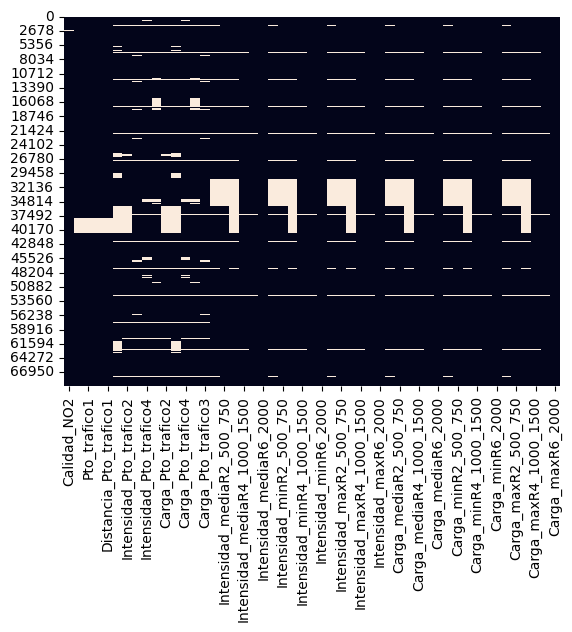

In [7]:
sns.heatmap(df[columnas_nulos].isnull().compute(),cbar=False)

In [9]:
for col in columnas_nulos:
    print(f"Columna {col} - {df[col].isnull().sum().compute()} nulos - Media {df[col].mean().compute()}")

Columna Calidad_NO2 - 314 nulos - Media 49.07984763443808
Columna Pto_trafico2 - 2880 nulos - Media 4860.044590281836
Columna Pto_trafico1 - 2880 nulos - Media 4953.346293882321
Columna Distancia_Pto_trafico2 - 2880 nulos - Media 246.23995493939833
Columna Distancia_Pto_trafico1 - 2880 nulos - Media 219.07531362369107
Columna Intensidad_Pto_trafico1 - 10187 nulos - Media 328.1421829255966
Columna Intensidad_Pto_trafico2 - 7176 nulos - Media 420.066108842446
Columna Intensidad_Pto_trafico3 - 2342 nulos - Media 548.1208338907226
Columna Intensidad_Pto_trafico4 - 2985 nulos - Media 509.72231351421726
Columna Intensidad_Pto_trafico5 - 4949 nulos - Media 505.81008653925676
Columna Carga_Pto_trafico2 - 7176 nulos - Media 19.623235113566587
Columna Carga_Pto_trafico1 - 10187 nulos - Media 20.000552433511555
Columna Carga_Pto_trafico4 - 2985 nulos - Media 24.12475613782337
Columna Carga_Pto_trafico5 - 4949 nulos - Media 24.82798325911262
Columna Carga_Pto_trafico3 - 2342 nulos - Media 17.83875

Voy a interpolar los datos para que se queden de una forma linear y para que funcionen mejor con la regresión

In [15]:
df_original = df
for col in columnas_nulos:
    df[col].fillna(df[col].mean().compute())

In [16]:
df.isnull().sum().compute()

id_pto_calidad      0
nombre_estacion     0
ALTITUD             0
tipo_estacion_id    0
fecha               0
                   ..
anyo                0
mes                 0
dia                 0
hora                0
diasemana           0
Length: 86, dtype: int64

In [17]:
new_df = df_original.dropna()
new_df.isnull().sum().compute()

id_pto_calidad      0
nombre_estacion     0
ALTITUD             0
tipo_estacion_id    0
fecha               0
                   ..
anyo                0
mes                 0
dia                 0
hora                0
diasemana           0
Length: 86, dtype: int64

Voy a intentar calcular una diferencia en las medias y voy a ver cual tiene más diferencia con la original

Vamos a calcular el error relativo con respecto de las medias originales para saber cuantos dígitos se hanvisto modificados $ Error Relativo = \frac{|real-estimacion|}{|real|} $

In [23]:
(da.abs(df_original.mean().compute()-df.mean().compute()))/(df_original.mean().compute())

id_pto_calidad    0.0
ALTITUD           0.0
Calidad_NO2       0.0
Pto_trafico2      0.0
Pto_trafico1      0.0
                 ... 
anyo              0.0
mes               0.0
dia               0.0
hora              0.0
diasemana         0.0
Length: 82, dtype: float64

In [24]:
(da.abs(df_original.mean().compute()-new_df.mean().compute()))/(df_original.mean().compute())

id_pto_calidad    0.005568
ALTITUD           0.005489
Calidad_NO2       0.035202
Pto_trafico2      0.036438
Pto_trafico1      0.032915
                    ...   
anyo              0.000022
mes               0.063474
dia               0.010288
hora              0.001749
diasemana         0.000855
Length: 82, dtype: float64

Como podemos ver, la media se ha visto bastante más afectada cuando hemos utilizado el método `dropna()` como una solución, en cambio interpolando los datos que faltaban hemos logrado algo mucho más cercano a la media original

No debería ser del todo así ya que en el caso de que esos datos cuyos valores eran `NaN` podrían haber sido otros datos cuales quiera y hacer que varía la media con la cual nosotros estamos considerando como la original

3